##《高级人工智能课程》作业
### 基于Pytorch的CIFAR10图像识别模型
### 要求
1.三个隐藏层，第一层100个节点，第二层50节点，第三层20节点

2.第一层激活函数relu，后两个tanh

3.dropout 0.5

4.epoch为30

5.评价指标：准确率、精确率

6.结果输出为csv

#### 参考链接
https://blog.csdn.net/a2213086589/article/details/113102896

https://blog.csdn.net/qq_41321169/article/details/111629742

https://zhuanlan.zhihu.com/p/497785636

http://t.zoukankan.com/xiximayou-p-14773460.html

https://zhuanlan.zhihu.com/p/317314397

1.导入库

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

2.参数设置

In [2]:
train_batch_size = 64
test_batch_size = 64
num_workers = 0 #线程数，win环境下最好为0
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')
lr = 0.001
momentum = 0.9

3.加载数据集

In [3]:
# 数据集直接在线下载失败，从官方下载数据到本地
# 彩色图片归一化，有三个通道transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
# 图片原始大小 3x32x32
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
train_dataset = torchvision.datasets.CIFAR10(root = 'D:/AI/Datasets', train=True, transform=transform, download=False)
test_dataset = torchvision.datasets.CIFAR10(root = 'D:/AI/Datasets', train=False, transform=transform, download=False)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size,shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size,shuffle=False, num_workers=num_workers)

4.数据可视化

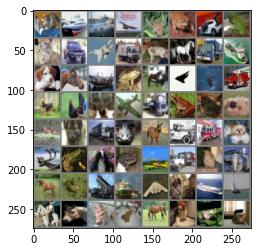

  cat ship shipplane


In [4]:
def imshow(img):
    img=img/2+0.5
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    #随机获取部分训练数据
dataiter=iter(test_loader)  #依次取出迭代器里的值。执行一次只能取到迭代器里的一个值
images,labels=dataiter.next()
#显示图像
imshow(torchvision.utils.make_grid(images))
print(''.join('%5s'% classes[labels[j]] for j in range(4) ))

5.全连接神经网络模型构建

In [5]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# class CNNNet(nn.Module):
#     def __init__(self):
#         super(CNNNet, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1)
#         self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
#         self.conv2 = nn.Conv2d(in_channels=16,out_channels=36,kernel_size=3,stride=1)
#         self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
#         #self.aap = nn.AdaptiveAvgPool2d(1)
#         self.fc1 = nn.Linear(1296,128)
#         self.fc2 = nn.Linear(128,10)
#         #self.fc3 = nn.Linear(36,10)
#     def forward(self,x):
#         x = self.pool1(F.relu(self.conv1(x)))
#         x = self.pool2(F.relu(self.conv2(x)))
#         #x = self.aap(x)
#         #x = x.view(x.shape[0],-1)
#         #x = self.fc3(x)
#         x = x.view(-1,36*6*6)
#         #print("x.shape:{}".format(x.shape))
#         x = F.relu(self.fc2(F.relu(self.fc1(x))))
#         return x

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3072, 100), # 32*32*3 =3072
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.Tanh(),
            nn.Linear(50, 20),
            nn.Tanh(),
            nn.Dropout(0.5) # 默认0.5
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

6.模型训练

In [6]:
model = NeuralNetwork()
model = model.to(device)
print('--------------查看网络结构-----------')
print(model)

--------------查看网络结构-----------
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=20, bias=True)
    (5): Tanh()
    (6): Dropout(p=0.5, inplace=False)
  )
)


In [7]:
## 加载预模型
# model.load_state_dict(torch.load('./model/model.pth'))#再加载网络的参数
# model = model.to(device)
# print("load success")
# print('--------------查看网络结构-----------')
# print(model)

In [8]:
print('-----训练优化器-------')
import torch.optim as optim
criterion = nn.CrossEntropyLoss() # 调参项
optimizer = optim.Adam(model.parameters(), lr=lr) # 调参项
print("----------正式训练模型---------")
losses = []
acces = []
eval_losses = []
eval_acces = []
for epoch in range(10):
    train_acc = 0
    train_loss = 0
    num_correct = 0
    model.train()
    for i, data in enumerate(train_loader):
        img, label = data
        img, label = img.to(device), label.to(device)
        #权重参数梯度清零
        optimizer.zero_grad()
        #正向反向传播
        out = model(img)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

        #计算损失值
        train_loss += loss.item()
        #计算准确率
        _, pred = out.max(1)
        num_correct += (pred == label).sum()
        if i % 100 == 99: #100 mini-batch输出一次
            print('[%d,%5d] loss : %.3f' % (epoch + 1, i + 1, train_loss / 2000))
            train_loss = 0.0
    acces.append(num_correct/(len(train_loader)*train_batch_size))

-----训练优化器-------
----------正式训练模型---------
[1,  100] loss : 0.128
[1,  200] loss : 0.122
[1,  300] loss : 0.120
[1,  400] loss : 0.120
[1,  500] loss : 0.120
[1,  600] loss : 0.119
[1,  700] loss : 0.118
[2,  100] loss : 0.117
[2,  200] loss : 0.116
[2,  300] loss : 0.117
[2,  400] loss : 0.117
[2,  500] loss : 0.117
[2,  600] loss : 0.116
[2,  700] loss : 0.117
[3,  100] loss : 0.115
[3,  200] loss : 0.116
[3,  300] loss : 0.115
[3,  400] loss : 0.116
[3,  500] loss : 0.116
[3,  600] loss : 0.115
[3,  700] loss : 0.116
[4,  100] loss : 0.114
[4,  200] loss : 0.116
[4,  300] loss : 0.115
[4,  400] loss : 0.115
[4,  500] loss : 0.115
[4,  600] loss : 0.114
[4,  700] loss : 0.115
[5,  100] loss : 0.113
[5,  200] loss : 0.114
[5,  300] loss : 0.113
[5,  400] loss : 0.114
[5,  500] loss : 0.114
[5,  600] loss : 0.114
[5,  700] loss : 0.115
[6,  100] loss : 0.114
[6,  200] loss : 0.113
[6,  300] loss : 0.112
[6,  400] loss : 0.114
[6,  500] loss : 0.114
[6,  600] loss : 0.114
[6,  700] los

7.模型测试

In [9]:
def get_acc_p_r_f1(trues, preds):
  labels = [0,1,2,3,4,5,6,7,8,9]
  TP,FP,FN,TN = 0,0,0,0
  for label in labels:
    preds_tmp = np.array([1 if pred == label else 0 for pred in preds])
    trues_tmp = np.array([1 if true == label else 0 for true in trues])
    # print(preds_tmp, trues_tmp)
    # print()
    # TP预测为1真实为1
    # TN预测为0真实为0
    # FN预测为0真实为1
    # FP预测为1真实为0
    TP += ((preds_tmp == 1) & (trues_tmp == 1)).sum()
    TN += ((preds_tmp == 0) & (trues_tmp == 0)).sum()
    FN += ((preds_tmp == 0) & (trues_tmp == 1)).sum()
    FP += ((preds_tmp == 1) & (trues_tmp == 0)).sum()
  # print(TP, FP, FN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  acc = (TP+TN)/ (TP+TN+FP+FN)
  f1 = 2 * precision * recall / (precision + recall)
  return precision

In [10]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
num_correct = 0
Precision = 0

data=np.array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])
Pred = torch.Tensor(data)
Pred = Pred.to(device)
# pred_ = pred.reshape(1,-1)

model.eval()
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        out = model(img)
        # 计算准确率
        _, pred = out.max(1)
        num_correct += (pred == label).sum()
#         pred_ = pred.reshape(1,-1)
        Pred = torch.cat((Pred , pred) ,dim = 0)

#         if Pred.shape == 16:
#             Pred=torch.stack((Pred,pred_) ,dim = 0)
#         else:
#             Pred=torch.cat((Pred,pred_) ,dim = 0)
            
        # 计算精确率
        precision =get_acc_p_r_f1(label,pred)
        Precision += precision
        # 计算各类别准确率
        c = (pred == label)
        for i in range(4):
            class_correct[label[i]] += c[i].item() #将True/False化为1/0
            class_total[label[i]] += 1
    print("准确率为:{}".format(num_correct/(len(test_loader)*test_batch_size)))
    print("精确率为:{}".format(Precision/(len(test_loader))))
    print("各类准确率为:")
    for i in range(10):
        print("accuracy of {}:{}%".format(classes[i],100*class_correct[i]/class_total[i]))

准确率为:0.46725717186927795
精确率为:0.46964570063694266
各类准确率为:
accuracy of plane:53.57142857142857%
accuracy of car:66.0%
accuracy of bird:24.050632911392405%
accuracy of cat:31.506849315068493%
accuracy of deer:29.09090909090909%
accuracy of dog:33.898305084745765%
accuracy of frog:53.57142857142857%
accuracy of horse:50.0%
accuracy of ship:75.86206896551724%
accuracy of truck:42.30769230769231%


In [11]:
Pred_ = Pred.reshape(-1,16).detach().cpu().numpy()
Pred_ = np.delete(Pred_, 0, axis=0)
print(Pred_)
np.savetxt('submission_CIFAR10.csv',Pred_,delimiter=',')

[[3. 1. 8. ... 7. 1. 8.]
 [5. 7. 8. ... 6. 6. 4.]
 [4. 3. 9. ... 9. 3. 8.]
 ...
 [5. 7. 8. ... 7. 6. 6.]
 [3. 9. 4. ... 7. 4. 1.]
 [4. 3. 8. ... 5. 5. 7.]]
